In [1]:
import sys
sys.path.append('../data/')
sys.path.append('../src/')
sys.path.append('../libs/')

import numpy as np
import tensorflow as tf
import scipy.linalg as la
import matplotlib.pyplot as plt

<center>
<h1>Graph Embedding by Convolution with Kernels that are Optimized (GECKO)</h1>
<img width=400px, src="https://4.bp.blogspot.com/-_4YSL3AIp0o/Ue5zT_jUweI/AAAAAAAAoms/NQTKfJHMbSg/s640/tokay+gecko+2.jpg"/>
</center>

<h2>Motivation</h2>

<h2>Architecture</h2>

In [15]:
def poly2ChebMatrix(n):
    
    # Initialize T0 and T1 base cases
    P = np.zeros((n, n))
    P[0,0] = 1
    P[1,1] = 1
    
    # Recursively fill in the rest of the matrix
    for i in range(2, n):        
        P[i,:] = 2 * np.pad(P[i-1,:], (1, 0), 'constant')[:-1] - P[i-2,:]
        
    return P

In [263]:
def new_model(nFilters1, nFilters2, nDims, nCoefs, L, L1, part1):
    '''
    nFilters1: Number of filters / kernels in convolutional layer 1
    nFilters2: Number of filters / kernels in convolutional layer 2
    nDims:     Dimension of embeddings
    nCoefs:    Order of filter polynomials (recommended < 10 for numerical stability)
    L:         (n1 x n1) Laplacian matrix for full graph
    L1:        (n2 x n2) Laplacian matrix for pooled graph 1
    part1:     (n1 x n2) Membership matrix for full graph -> pooled graph 1
    '''
    
    # Get dimensions
    nVertices, nVertices1 = L.shape[0], L1.shape[0]
    
    # Compute Graph Fourier Transform matrices
    [lamb, U] = np.linalg.eig(L)
    [lamb1, U1] = np.linalg.eig(L1)

    # Calculate Chebyshev change-of-basis matrix
    powers = np.transpose(np.expand_dims(np.arange(nCoefs), 1))
    freqs, freqs1 = np.expand_dims(lamb, 1), np.expand_dims(lamb1, 1)
    Y, Y1 = np.power(freqs, powers), np.power(freqs1, powers)
    P = poly2ChebMatrix(nCoefs)
    T, T1 = np.dot(Y, P), np.dot(Y1, P)
    
    # Define model function
    def model_fn(features, labels, mode, params):

        # 1. Configure model via TensorFlow operations (support auto differentiation)

        # Define / randomly initialize parameters to train
        # theta1: Chebyshev polynomial weights for convolutional layer 1
        # theta2: Chebyshev polynomial weights for convolutional layer 2
        # weights: Coefficients for final dense layer
        theta1 = tf.Variable(np.random.normal(0, 1e-2, size = (nCoefs, nFilters1)))
        theta2 = tf.Variable(np.random.normal(0, 1e-2, size = (nCoefs, nFilters1, nFilters2)))
        weights = tf.Variable(np.random.normal(0, 1e-2, size = (nVertices * nFilters1 * nFilters2, nDims)))

        # INPUT LAYER
        # x: (nVertices x N) Input data (N is batch size, determined by Tensorflow)
        # x_hat: (1 x nVertices x N) Input data in frequency domain
        x = tf.transpose(tf.reshape(features['x'], (-1, nVertices)))
        x_hat = tf.expand_dims(tf.matmul(np.transpose(U), x), axis = 0)
        
        # CONVOLUTIONAL LAYER 1
        # filter1_hat: (nFilters1 x nVertices x 1) Filters in frequency domain
        # conv1_hat: (nFilters1 x nVertices x N) Convolution in frequency domain
        # conv1: (nFilters1 x nVertices x N) Convolution in vertex domain
        filter1_hat = tf.expand_dims(tf.tensordot(T, theta1, [[1], [0]]), axis = 2)
        filter1_hat = tf.transpose(filter1_hat, [1, 0, 2]) 
        conv1_hat = x_hat * filter1_hat 
        conv1 = tf.tensordot(conv1_hat, U, axes = [[1], [1]])
                
        # POOLING LAYER 1
        # coarse1: (nFilters1 x nVertices1 x N) Average of conv1 signal in each graph partition
        # coarse1_hat: (1 x nFilters1 x nVertices1 x N) coarse1 in frequency domain
        coarse1 = tf.tensordot(conv1, part1, [[1], [0]]) / np.sum(part1, axis = 0)
        coarse1_hat = tf.expand_dims(tf.tensordot(np.transpose(U1), coarse1, [[1], [1]]), axis = 0)
        
        # CONVOLUTIONAL LAYER 2
        # filter2_hat: (nFilters2 x nFilters1 x nVertices1 x 1) Filters in frequency domain
        # conv2_hat: (nFilters2 x nFilters1 x nVertices1 x N) Convolutions in freq. domain
        # conv2: (nFilters2 x nFilters1 x nVertices1 x N) Convolution in vertex domain
        filter2_hat = tf.expand_dims(tf.tensordot(T1, theta2, [[1], [0]]), axis = 3)
        filter2_hat = tf.transpose(filter2_hat, [2, 1, 0, 3])
        conv2_hat = coarse1_hat * filter2_hat
        conv2 = tf.tensordot(U1, conv2_hat, axes = [[1], [2]])
        
        # DENSE (OUTPUT) LAYER
        # conv_out: (nFilters2 * nFilters1 * nVertices1 x N) Flattened convolution outputs
        # embed: (N x n_dims) Embedding of each graph in the nDims-dimensional plane
        conv_out = tf.reshape(conv2, (nFilters1 * nFilters2 * nVertices1, -1))
        embed = tf.sigmoid(tf.matmul(tf.transpose(conv_flat), weights))

        # If we are predicting, and not calculating loss, stop now.
        if mode == tf.estimator.ModeKeys.PREDICT:
            return tf.estimator.EstimatorSpec(mode, {'embed': embed})

        # 2. Define loss function

        # Loss is computed by squared error between predicted graph distance
        # versus desired graph distance.
        # If images are in the same class, the distance should be zero.
        # Otherwise, distance should be higher.
        loss = tf.losses.mean_squared_error(labels, embed)

        # 3. Define training operation / optimizer

        optimizer = tf.train.GradientDescentOptimizer(learning_rate = params['learning_rate'])
        train_op = optimizer.minimize(loss = loss, global_step = tf.train.get_global_step())

        return tf.estimator.EstimatorSpec(mode, embed, loss, train_op, {})
    
    return model_fn

<h2>Network Test Cases</h2>

In [232]:
# Load Data
laplacian_path = "../data/cases/fullLaplacian.csv"
laplacian1_path = "../data/cases/coarseLaplacian.csv"
part1_path = "../data/cases/partition.csv"
processA_data_path = "../data/cases/procASignals.csv"
processB_data_path = "../data/cases/procBSignals.csv"

L = np.loadtxt(laplacian_path, delimiter = ',')
L1 = np.loadtxt(laplacian1_path, delimiter = ',')
part1 = np.loadtxt(part1_path, delimiter = ',')
A = np.loadtxt(processA_data_path, delimiter = ',')
B = np.loadtxt(processB_data_path, delimiter = ',')

In [233]:
# Combine Data
allData = np.vstack((A, B))

labels = np.vstack((np.hstack((np.ones(A.shape[0]), np.zeros(B.shape[0]))),
    np.hstack((np.zeros(B.shape[0]), np.ones(B.shape[0])))))
labels = np.transpose(labels)

# Shuffle data
idx = np.random.permutation(labels.shape[0])
allData, labels = allData[idx,:], labels[idx]
allData = allData / np.expand_dims(np.max(allData, axis = 1), axis = 1)

In [234]:
# Create input function
training_input_fn = tf.estimator.inputs.numpy_input_fn(
    x = {'x': allData},
    y = labels,
    shuffle = True,
    num_epochs = 10
)

In [264]:
nCoefs = 6
nFilters1 = 10
nFilters2 = 10
nDims = 2

model_params = {'learning_rate': 0.001}

model_fn = new_model(nFilters1, nFilters2, nDims, nCoefs, L, L1, part1)
nn = tf.estimator.Estimator(model_fn = model_fn, params = model_params)
est = nn.train(input_fn = training_input_fn, steps = None)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\KEVINS~1\\AppData\\Local\\Temp\\tmpd20pgtki', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000000002303D1D0>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


ValueError: Dimensions must be equal, but are 27 and 100 for 'Tensordot_3/MatMul' (op: 'MatMul') with input shapes: [27,27], [100,270].

In [227]:
predict_input_fn = tf.estimator.inputs.numpy_input_fn(
    x = {'x': allData},
    num_epochs = 1,
    shuffle=False)

predictions = nn.predict(input_fn = predict_input_fn)
embeddings = np.vstack([pred['embed'] for pred in predictions])

INFO:tensorflow:Restoring parameters from C:\Users\KEVINS~1\AppData\Local\Temp\tmpeu615hpm\model.ckpt-1563


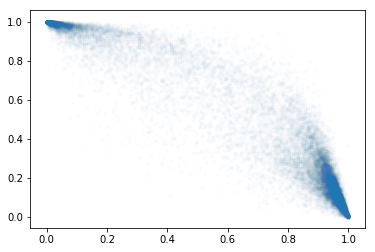

In [228]:
plt.scatter(embeddings[:, 0], embeddings[:, 1], marker = '.', alpha = 0.01)
plt.show()